In [63]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import scipy
import scipy.integrate as integrate
import scipy.stats as sps
from scipy.stats import beta as beta_dist
from scipy.stats import cauchy, gamma, norm, dirichlet, expon, uniform, invgauss, mode 
import time
import pandas as pd
from random import choices


In [64]:
def genParam(n, randomstate) :
    r = np.random.RandomState(seed=randomstate)
    
    alpha = r.exponential(1,(n,3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1,n) :
      betai = [r.dirichlet(alpha[i])]
      beta = np.concatenate((beta,betai), axis=0)
    
    mu = [[beta[0][0]-beta[0][1], 2*(beta[0][0]+beta[0][1])-1]]
    for i in range(1,n) :
      mui = [[beta[i][0]-beta[i][1], 2*(beta[i][0]+beta[i][1])-1]]
      mu = np.concatenate((mu, mui),axis=0)
    sigma = r.wald(ksi[0], ksi[1],n)
    
    return(alpha, ksi, beta, mu, sigma)

In [65]:
def genX(n, T, mu, sigma) :
    A = np.eye(T, T+2) + mu[0][0]*np.eye(T, T+2,1) + mu[0][1]*np.eye(T, T+2,2)
    A = A@A.T
    X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
    for i in range(1,n) :
      A = np.eye(T, T+2) + mu[i][0]*np.eye(T, T+2,1) + mu[i][1]*np.eye(T, T+2,2)
      A = sigma[i]*A@A.T
      Xi = [np.random.multivariate_normal(np.zeros(T), A)]
      X = np.concatenate((X,Xi), axis=0)
    return(X)

Algorithme 1 : Gibbs-ABC

In [66]:
def prior(n, hyper):
    X_1 = beta_dist.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta_dist.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def distautcor(Z, X):
    min_length = min(len(Z), len(X))
    Z = Z[:min_length]
    X = X[:min_length]
    
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)

In [67]:
def ABCbas(X, N, T, mu, sigma):
    distances = []
    for i in range(N):
        simulated_X = genX(1, T, [mu], [sigma])  
        simulated_X = np.array(simulated_X) 
        distance = distautcor(X.flatten(), simulated_X.flatten())
        distances.append((distance, mu, sigma))
    min_distance_index = np.argmin([d[0] for d in distances])
    distance_values = np.array([d[0] for d in distances])
    return distances[min_distance_index][1], distances[min_distance_index][2]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Eviter la division par 0
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])

def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = expon.rvs(size=(L, 3))  
    dist = np.zeros(L)
    for i in range(L):
        U = prior(len(Q1), hyper[i]) 
        dist[i] = np.sum((statdir(U) - statdir(Q))**2)
    return hyper[np.argmin(dist)]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N, T):
    dist = np.zeros(N)
    w = np.arange(1, min(Dat.shape[0], 10))
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        simulated_data = genX(1, T, np.array([[parh1[j], parh2[j]]]), np.array([si[i]]))
        simulated_data = np.array(simulated_data)
        if j >= Dat.shape[1]:
            raise IndexError(f"Index {j} is out of bounds for axis 1 with size {Dat.shape[1]}")
        valid_w = w[w < Dat.shape[0]] 
        if len(valid_w) == 0:
            raise ValueError("No valid indices in w for accessing Dat.")
        dist[i] = np.abs(np.var(simulated_data.flatten()[valid_w]) - np.var(Dat[valid_w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    pri = np.abs(cauchy.rvs(size=(Q, 2)))
    for i in range(Q):
        h = pri[i]
        y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist)]

In [68]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        # mu_updates = []  # Cette ligne est commentée car mu ne sera pas mis à jour
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            # mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])  # mu_best n'est plus nécessaire
            sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])[1]  # On récupère seulement sigma_best
            # mu[j] = mu_best  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma[j] = sigma_best
            # mu_updates.append(mu_best)  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        # results["Paramètres_mu"].append(mu_updates)  # Cette ligne est commentée car mu ne sera pas mis à jour
        results["Paramètres_sigma"].append(sigma_updates)
        
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [69]:
N = 30  # Nombre de simulations pour les paramètres
M = 30  # Nombre de simulations pour l'hyperparamètre
P = 30  # Nombre de simulations pour sigma
P2 = 30  # Nombre de simulations pour hypersigma
Npts = 1000 # Nombre total d'itérations de l'algorithme global

n = 5  #Nombre de trajectoires dans les données d'entrée
T = 40 # Longueur des trajectoires dans les données d'entrée

objectifeps = 8 # Seuil de niveau d'erreur entre les données simulées et les données observées
temps_max = 10  # Temps d'éxecution maximum de l'algorithme global en secondes

alpha, ksi, beta, mu, sigma=genParam(n, randomstate=0)
X=genX(n, T, mu, sigma)

hypersigm_real= ksi

In [70]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
resultats

C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:46: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 10 secondes atteint à la 7ème itération.


{'Paramètres_sigma': [[0.004691123263026888,
   0.0053685810625457514,
   0.006260961093463038,
   0.004901985601723259,
   0.004893692718171779,
   0.005348573192353696,
   0.0060089333403119324,
   0.005773195495225366,
   0.00507602074283653,
   0.005578690765388634,
   0.005804279704915846,
   0.005830258572196381,
   0.005794028532946113,
   0.006103920950474691,
   0.006639100706522165,
   0.00688432934062642,
   0.005634210741250379,
   0.005340612469483693,
   0.006686603141162015,
   0.005290946095746609,
   0.0050032438637526615,
   0.00746721279016238,
   0.005528649352318847,
   0.00680160128112345,
   0.00552680106436274,
   0.006457896133802036,
   0.006937650503688867,
   0.006244076989751558,
   0.005658814840120528,
   0.006179482677839679,
   0.006006580828980818,
   0.005297518215628718,
   0.007151829271878551,
   0.005378902935434269,
   0.005475925999041283,
   0.0055070330918703825,
   0.0063987591769808375,
   0.0066762187217214225,
   0.0061586704320845155,
   

In [71]:
def distance(resultats, hypersigm_real):

    hypersigm_real=np.array(hypersigm_real)

    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    return {
        'Distance Hypersigma': distance_hypersigm
    }

In [72]:
def calculate_quadratic_error_individual_components(estimated_hypersigma, real_hypersigma):
    # Ensure that real_hypersigma is a numpy array for element-wise operations
    real_hypersigma = np.array(real_hypersigma)
    
    # Calculate the mean of the estimated hypersigma values for each component
    mean_estimated_hypersigma_0 = np.mean([est[0] for est in estimated_hypersigma])
    mean_estimated_hypersigma_1 = np.mean([est[1] for est in estimated_hypersigma])
    
    # Compute the bias for each component
    bias_0 = mean_estimated_hypersigma_0 - real_hypersigma[0]
    bias_1 = mean_estimated_hypersigma_1 - real_hypersigma[1]
    
    # Compute the variance for each component
    variance_0 = np.var([est[0] for est in estimated_hypersigma])
    variance_1 = np.var([est[1] for est in estimated_hypersigma])
    
    # Compute the quadratic error for each component as bias squared plus variance
    quadratic_error_0 = bias_0**2 + variance_0
    quadratic_error_1 = bias_1**2 + variance_1
    
    return quadratic_error_0, quadratic_error_1

In [73]:
temps_max_values = [10, 30, 60, 120]
standard_error_hypersigma = []
distance_hypersigm = []
epsilon=[]
erreur_quadratique_0=[]
erreur_quadratique_1=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hypersigma=resultats["Hypersigma"]
    std_hypersigma = np.std(hypersigma)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats, hypersigm_real)
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hypersigm.append(dist_hypersigm)
    erreur_quadra_0,erreur_quadra_1= calculate_quadratic_error_individual_components(hypersigma, hypersigm_real)
    erreur_quadratique_0.append(erreur_quadra_0)
    erreur_quadratique_1.append(erreur_quadra_1)


C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
C:\Users\sarah\AppData\Local\Temp\ipykernel_24216\949033940.py:46: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 10 secondes atteint à la 7ème itération.
Temps maximum d'exécution de 30 secondes atteint à la 11ème itération.
Temps maximum d'exécution de 60 secondes atteint à la 15ème itération.
Temps maximum d'exécution de 120 secondes atteint à la 30ème itération.


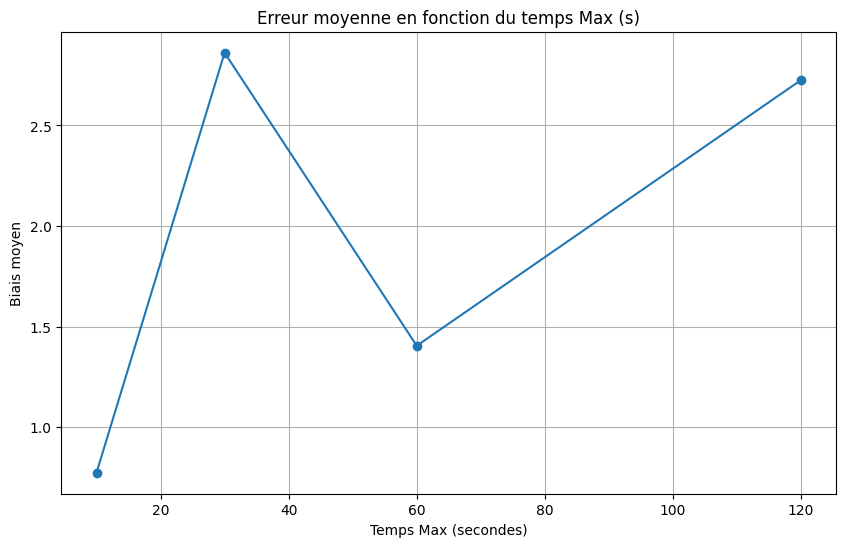

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm , marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

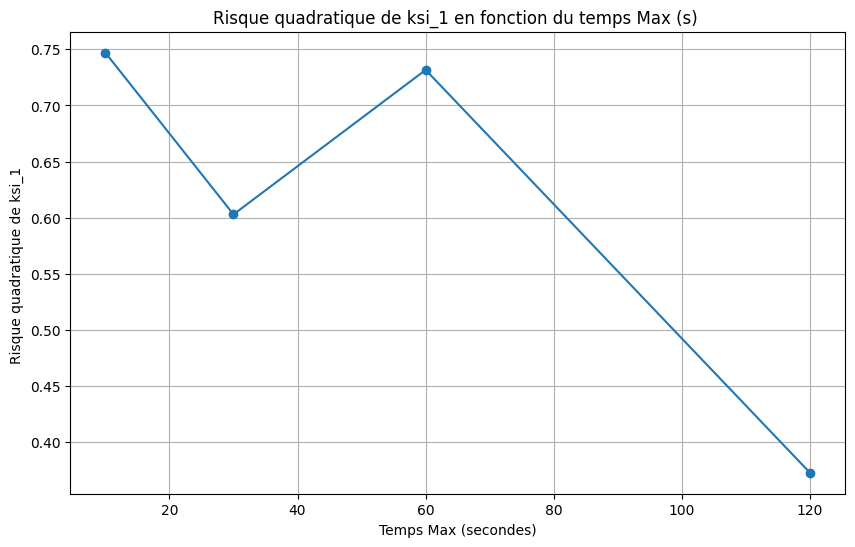

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_0, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_1 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_1 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

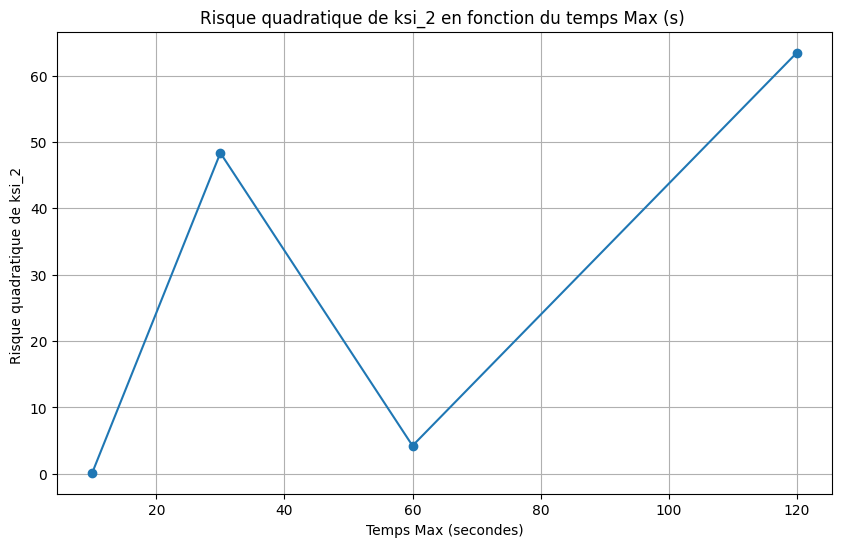

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, erreur_quadratique_1, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_2 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_2 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

Algorithme 2

In [77]:
def changepoids(simui, nouveps, eps, T, M): #fonction qui sous-pondère les propositions les plus éloignées du dataset
    if simui[0]==0:
        return(simui)
    if sum(simui[T+9:T+M+9]<= eps) == 0:
        simui[1] = 0
        return(simui)
    simui[1]=simui[0]*sum(simui[T+9:T+M+9]<= nouveps)/sum(simui[T+9:T+M+9]<= eps)
    return(simui)
    
def changementeps(simu, eps, alpha, n, M, T):
    epsilons = np.sort(simu[:,T+9:M+T+9][simu[:,T+9:M+T+9]<eps])[::-1]
    nbops = len(epsilons)
    #print("nbops", nbops)
    no = nbops
    ESS = 1/sum(simu[:,0]**2)
    k = int((1-alpha)*ESS*no/n/2)
    while (k<nbops-1):
        nouveps = epsilons[k]
        a=True
        simu = np.apply_along_axis(lambda x : changepoids(x, nouveps, eps,T, M),1,simu)
        simu[:,1] = simu[:,1] / sum(simu[:,1])
        nouvESS = 1/sum(simu[:,1]**2)
        if nouvESS < (alpha * ESS) :
            simu[:,0] = simu[:,1]
            simu[:,1] = np.zeros(n)
            return(simu, nouveps, nouvESS)
        k += max(1,int((nouvESS-alpha*ESS)*(no-k)/n/2))
    return(simu,eps,ESS)

def chgtpar(simui, sdsigma, eps, dprior, dist, n, M, T):
    varsigma = np.random.multivariate_normal(np.zeros(T),cov=sdsigma)
    simu = np.abs(simui + np.concatenate((np.zeros(9),varsigma,np.zeros(M))))
    matcalc = simu[9:T+9]
    vwald = np.var(matcalc)
    ewald = np.mean(matcalc)
    ksi1 = ewald
    ksi2 = ewald**3/vwald
    simu[5:7] = np.array([ksi1, ksi2])
    simu[T+9:T+M+9] = dist(simu)
    snew = sum(simu[T+9:T+M+9] <= eps)
    sold = sum(simui[T+9:T+M+9] <= eps)
    u = np.random.uniform(1)
    if sold == 0:
        return(simui)
    if (u < (snew / sold * dprior(simu) / dprior(simui))):
        return(simu)
    else :
        return(simui)
        
def smc(data, n, M, maxiter, objectifeps, alpha, rprior, dprior, dist, T, tempsmax): 
    #data : dataset de comparaison
    #rprior : fonction de proposition initiale
    #dprior : fonction de densité de la proposition
    #dist : distance euclicienne des déciles de propositions par rapport au dataset
    #simu contient n lignes (propositions) X 9 colonnes d'informations, T colonnes de moyennes mobiles et M colonnes de distances
    start_time = time.time()
    simu = np.concatenate((np.zeros((n,2)),np.abs(rprior(n))), axis = 1)
    distances = np.apply_along_axis(dist,1,simu)
    simu = np.concatenate((simu,distances), axis = 1)
    j=1
    simu[:,0] = np.array([1/n]*n)
    ESS = n 
    #taille estimée de l'ensemble pondéré
    eps = np.max(simu[:,T+9:M+T+9])
    histeps = [eps]
    while ((j<maxiter) and (eps>objectifeps) and (time.time()-start_time < tempsmax)):
        (simu, eps, ESS) = changementeps(simu, eps, alpha, n, M, T) #fonction qui sous-pondère les propositions les plus éloignées du dataset
        histeps.append(eps)
        if (ESS < n / 2) :
            simu = np.array(choices(simu, weights = simu[:,0], k = n)) 
            #quand l'ensemble de propositions devient trop petit, un nouvel ensemble de taille n est tiré avec remise et pondération parmi les précédentes
            simu[:,0] = np.array([1/n]*n)
            ESS = n
            simu[:,T+9:M+T+9] = np.apply_along_axis(dist,1,simu)
        simumat = simu[:,9:T+9].reshape(n,T)
        sdsigma = 2 * np.cov(np.transpose(simumat))
        simu = np.apply_along_axis(lambda x : chgtpar(x, sdsigma, eps, dprior, dist, n, M, T),1,simu)
        #une tentative de modification est faite sur chaque proposition
        j += 1
    #un dernier tirage est fait
    simu = np.array(choices(simu, weights = simu[:,0], k = n))
    poids = np.array([1/n]*n)
    ESS = n
    distances = np.array([dist(i) for i in simu]*M)
    return(simu, histeps)

In [78]:
M = 30
n = 100
T = 40
randomstate = 0
alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
X = genX(n, T, mu, sigma)
#Les données sont générées commes pour les autres algorithmes avec un n plus élevé 

def gen(mu1,mu2,s,n):
    A = np.random.normal(0,max(s,0),n+2)
    return(A[2:(n + 2)] + mu1 * A[1:(n + 1)] + mu2 * A[0:n])

def rprior(n):
    alphas = alpha
    ksis = np.abs(np.random.standard_cauchy(size = (n,2)))
    mus = mu
    res2 = np.apply_along_axis(lambda x : np.random.wald(x[0], x[1], size = T),1,ksis)
    return(np.concatenate((alphas,ksis,mus,res2.reshape(n,-1)),axis=1))

statdata = np.apply_along_axis(lambda x : np.percentile(x, np.arange(10, 91, 10)),0,X)
        
def dprior(simui):
    ksi1 = simui[5]
    ksi2 = simui[6]
    matsim = np.expand_dims(simui[9:T+9], axis = 1)
    return(np.sum(np.apply_along_axis(lambda s : invgauss.pdf(s[0], mu = ksi1/ksi2, scale = ksi2), 1, matsim)))

def dist(simui):
    lev = np.arange(0.1, 0.91, 0.1)
    mu1 = simui[8]
    mu2 = simui[9]
    s = np.expand_dims(simui[9:T+9], axis=1)
    somme = np.apply_along_axis(lambda i : np.sum(np.abs(np.apply_along_axis(lambda x : np.percentile(gen(mu1, mu2, x[0], n), np.arange(10,91,10)),0,s)-statdata)),1,np.zeros((M,1)))
    return(somme)

In [79]:
result10 = np.zeros((10,n,79))
temps = 10
for i in range(10):
    res, hist = smc(X, n, M, 150, 50, 0.9, rprior, dprior, dist, T, temps)
    result10[i] = res
result20 = np.zeros((10,n,79))
temps = 20
for i in range(10):
    res, hist = smc(X, n, M, 150, 50, 0.9, rprior, dprior, dist, T, temps)
    result20[i] = res
result30 = np.zeros((10,n,79))
temps = 30
for i in range(10):
    res, hist = smc(X, n, M, 150, 50, 0.9, rprior, dprior, dist, T, temps)
    result30[i] = res
result60 = np.zeros((10,n,79))
temps = 60
for i in range(10):
    res, hist = smc(X, n, M, 150, 50, 0.9, rprior, dprior, dist, T, temps)
    result60[i] = res
result120 = np.zeros((10,n,79))
temps = 120
for i in range(10):
    res, hist = smc(X, n, M, 150, 50, 0.9, rprior, dprior, dist, T, temps)
    result120[i] = res

In [ ]:
print(np.sqrt((np.mean(result10[:,:,5])-ksi[0])**2+(np.mean(result10[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result20[:,:,5])-ksi[0])**2+(np.mean(result20[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result30[:,:,5])-ksi[0])**2+(np.mean(result30[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result60[:,:,5])-ksi[0])**2+(np.mean(result60[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result120[:,:,5])-ksi[0])**2+(np.mean(result120[:,:,6])-ksi[1])**2))
ksi110 = result10[:,:,5]
ksi120 = result20[:,:,5]
ksi130 = result30[:,:,5]
ksi160 = result60[:,:,5]
ksi1120 = result120[:,:,5]
ksi210 = result10[:,:,6]
ksi220 = result20[:,:,6]
ksi230 = result30[:,:,6]
ksi260 = result60[:,:,6]
ksi2120 = result120[:,:,6]
print(np.mean(np.apply_along_axis(np.var,1,ksi110))+(np.mean(result10[:,:,5])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi210))+(np.mean(result10[:,:,6])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi120))+(np.mean(result20[:,:,5])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi220))+(np.mean(result20[:,:,6])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi130))+(np.mean(result30[:,:,5])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi230))+(np.mean(result30[:,:,6])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi160))+(np.mean(result60[:,:,5])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi260))+(np.mean(result60[:,:,6])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi1120))+(np.mean(result120[:,:,5])-ksi[0])**2)
print(np.mean(np.apply_along_axis(np.var,1,ksi2120))+(np.mean(result120[:,:,6])-ksi[0])**2)

In [ ]:
er10 = 7.656633918599754
er20 = 3.5512770276343626
er30 = 1.7658691389749934
er60 = 2.4653378601507896
er120 = 1.818859251417876
tmax =[10,20,30,60,120]
erreurs = [er10,er20, er30,er60,er120]

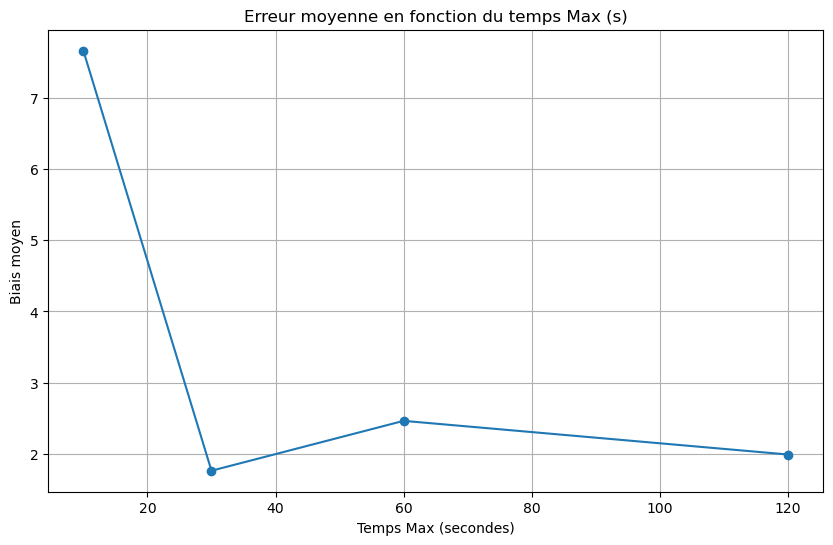

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, erreurs, marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

In [ ]:
ksi1ris10 = 162.48950328764573
ksi1ris20 = 136.49795426515382
ksi1ris30 = 39.12395004825525
ksi1ris60 = 95.33999545267613
ksi1ris120 = 28.218073652225694
tmax =[10,20,30,60,120]
risques = [ksi1ris10,ksi1ris20,ksi1ris30,ksi1ris60,ksi1ris120]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, risques, marker='o', linestyle='-')
plt.title('Risque quadratique de ksi_1 en fonction du temps Max (s) ')
plt.ylabel('Risque quadratique de ksi_1 ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

In [85]:
def MH(n, T, tempsmax, randomstate) :
    
    time0 = time.time()
    
    #Génération des données observées
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    X = genX(n, T, mu, sigma)
    
    #Génération de l'état initial
    ksiMH = [np.abs(np.random.standard_cauchy(2))]
    sigmaMH = [np.random.wald(ksiMH[0][0], ksiMH[0][1], n)]
    
    #Génération de la chaîne de Markov
    i=0
    while (time.time()-time0 < tempsmax) :
        L = 1
    
        #Génération des propositions
        ksiMHprop = [np.random.exponential(scale=ksiMH[i][0]), np.random.exponential(scale=ksiMH[i][1])]
        sigmaMHprop = []
        for k in range(n) :
            sigmaMHprop.append(np.random.exponential(scale=sigmaMH[i][k]))
        Lprop = 1
        
        for j in range(n):
    
            AMH = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMH = sigmaMH[i][j]*(AMH@AMH.T)
    
            L = L*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMH)
            L = L*scipy.stats.invgauss.pdf(sigmaMH[i][j], mu=ksiMH[i][0]/ksiMH[i][1], loc=0, scale=ksiMH[i][1])
    
            AMHprop = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMHprop = sigmaMHprop[j]*(AMHprop@AMHprop.T)
                
            Lprop = Lprop*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMHprop)
            Lprop = Lprop*scipy.stats.invgauss.pdf(sigmaMHprop[j], mu=ksiMHprop[0]/ksiMHprop[1], loc=0, scale=ksiMHprop[1])
    
        L = L*scipy.stats.halfcauchy.pdf(ksiMH[i][0])*scipy.stats.halfcauchy.pdf(ksiMH[i][1])
        Lprop = Lprop*scipy.stats.halfcauchy.pdf(ksiMHprop[0])*scipy.stats.halfcauchy.pdf(ksiMHprop[1])
    
        num = 1
        den = 1
        for k in range(n) :
            num = num*scipy.stats.expon.pdf(sigmaMH[i][k], scale=sigmaMHprop[k])
            den = den*scipy.stats.expon.pdf(sigmaMHprop[k], scale=sigmaMH[i][k])
        num = num*scipy.stats.expon.pdf(ksiMH[i][0], scale=ksiMHprop[0])*scipy.stats.expon.pdf(ksiMH[i][1], scale=ksiMHprop[1])
        den = den*(scipy.stats.expon.pdf(ksiMHprop[0], scale=ksiMH[i][0])*scipy.stats.expon.pdf(ksiMHprop[1], scale=ksiMH[i][1]))
        num = num*Lprop
        den = den*L
        if den == 0 :  
            ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
            sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
            #ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
            #sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
        else :
            r = min(1, num/den)
            if np.random.uniform() <= r:
                ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
            else : 
                ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)

        i+=1
    ksiMH = ksiMH[int(-np.floor(ksiMH.shape[0]*0.4)):]
    sigmaMH = sigmaMH[int(-np.floor(sigmaMH.shape[0]*0.4)):]

    meanksiMH = [np.mean(ksiMH[:, 0]), np.mean(ksiMH[:, 1])]
    meansigmaMH = []
    for i in range(n) :
        meansigmaMH.append(np.mean(sigmaMH[:, i]))
              
    return(meanksiMH[0], meanksiMH[1])

In [ ]:
ksi = genParam(30, 0)[1]

n = 2
est10 = np.zeros((2,n))
est20 = np.zeros((2,n))
est30 = np.zeros((2,n))
est60 = np.zeros((2,n))
est120 = np.zeros((2,n))
for i in range(n) :
    est10[0][i], est10[1][i] = MH(30, 40, 10, 0)
    est20[0][i], est20[1][i] = MH(30, 40, 20, 0)
    est30[0][i], est30[1][i] = MH(30, 40, 30, 0)
    est60[0][i], est60[1][i] = MH(30, 40, 60, 0)
    est120[0][i], est120[1][i] = MH(30, 40, 120, 0)

In [ ]:
mest10 = [np.mean(est10[0]), np.mean(est10[1])]
mest20 = [np.mean(est20[0]), np.mean(est20[1])]
mest30 = [np.mean(est30[0]), np.mean(est30[1])]
mest60 = [np.mean(est60[0]), np.mean(est60[1])]
mest120 = [np.mean(est120[0]), np.mean(est120[1])]

err10 = np.linalg.norm(mest10-ksi)
err20 = np.linalg.norm(mest20-ksi)
err30 = np.linalg.norm(mest30-ksi)
err60 = np.linalg.norm(mest60-ksi)
err120 = np.linalg.norm(mest120-ksi)

errquad10 = [np.var(est10[0]) + (mest10[0])-ksi[0])**2, np.var(est10[1]) + (mest10[1]-ksi[1])**2]
errquad20 = [np.var(est20[0]) + (mest20[0])-ksi[0])**2, np.var(est20[1]) + (mest20[1]-ksi[1])**2]
errquad30 = [np.var(est30[0]) + (mest30[0])-ksi[0])**2, np.var(est30[1]) + (mest30[1]-ksi[1])**2]
errquad60 = [np.var(est60[0]) + (mest60[0])-ksi[0])**2, np.var(est60[1]) + (mest60[1]-ksi[1])**2]
errquad120 = [np.var(est120[0]) + (mest120[0])-ksi[0])**2, np.var(est120[1]) + (mest120[1]-ksi[1])**2]

In [ ]:
tempsmax = [10, 20, 30, 60, 120]
err = [err10, err20, err30, err60, err120]
errquadksi1 = [errquad10[0], errquad20[0], errquad30[0], errquad60[0], errquad120[0]]
errquadksi2 = [errquad10[1], errquad20[1], errquad30[1], errquad60[1], errquad120[1]]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, err, marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, errquadksi1, marker='o', linestyle='-')
plt.title('Erreur quadratique ksi1 moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Erreur quadratique ksi1')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, errquadksi2, marker='o', linestyle='-')
plt.title('Erreur quadratique ksi2 en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Erreur quadratique ksi2')
plt.grid(True)
plt.show()

In [ ]:
a = 2

In [ ]:
ksi = genParam(30, 0)[1]

n = 10
est10 = np.zeros((2,n))
est20 = np.zeros((2,n))
est30 = np.zeros((2,n))
est60 = np.zeros((2,n))
est120 = np.zeros((2,n))
for i in range(n) :
    est10[0][i], est10[1][i] = MH(30, 40, 10, 0)
    est20[0][i], est20[1][i] = MH(30, 40, 20, 0)
    est30[0][i], est30[1][i] = MH(30, 40, 30, 0)
    est60[0][i], est60[1][i] = MH(30, 40, 60, 0)
    est120[0][i], est120[1][i] = MH(30, 40, 120, 0)

array([[1.20400605, 2.40425611, 1.53628603, 1.88782404, 0.65875741,
        2.34631149, 2.37264125, 1.56361005, 0.08060722, 0.80290354],
       [2.40037177, 2.84546209, 0.99258668, 0.33479326, 0.08199198,
        0.80359202, 0.36642472, 0.36418119, 2.07387527, 8.32529074]])

In [92]:
mest10 = [np.mean(est10[0]), np.mean(est10[1])]
mest20 = [np.mean(est20[0]), np.mean(est20[1])]
mest30 = [np.mean(est30[0]), np.mean(est30[1])]
mest60 = [np.mean(est60[0]), np.mean(est60[1])]
mest120 = [np.mean(est120[0]), np.mean(est120[1])]

err10 = np.linalg.norm(mest10-ksi)
err20 = np.linalg.norm(mest20-ksi)
err30 = np.linalg.norm(mest30-ksi)
err60 = np.linalg.norm(mest60-ksi)
err120 = np.linalg.norm(mest120-ksi)

errquad10 = [(np.var(est10[0]) + (mest10[0]-ksi[0])**2), (np.var(est10[1]) + (mest10[1]-ksi[1])**2)]
errquad20 = [(np.var(est20[0]) + (mest20[0]-ksi[0])**2), (np.var(est20[1]) + (mest20[1]-ksi[1])**2)]
errquad30 = [(np.var(est30[0]) + (mest30[0]-ksi[0])**2), (np.var(est30[1]) + (mest30[1]-ksi[1])**2)]
errquad60 = [(np.var(est60[0]) + (mest60[0]-ksi[0])**2), (np.var(est60[1]) + (mest60[1]-ksi[1])**2)]
errquad120 = [(np.var(est120[0]) + (mest120[0]-ksi[0])**2), (np.var(est120[1]) + (mest120[1]-ksi[1])**2)]

In [97]:
tmax = [10, 20, 30, 60, 120]
err = [err10, err20, err30, err60, err120]
errquadksi1 = [errquad10[0], errquad20[0], errquad30[0], errquad60[0], errquad120[0]]
errquadksi2 = [errquad10[1], errquad20[1], errquad30[1], errquad60[1], errquad120[1]]

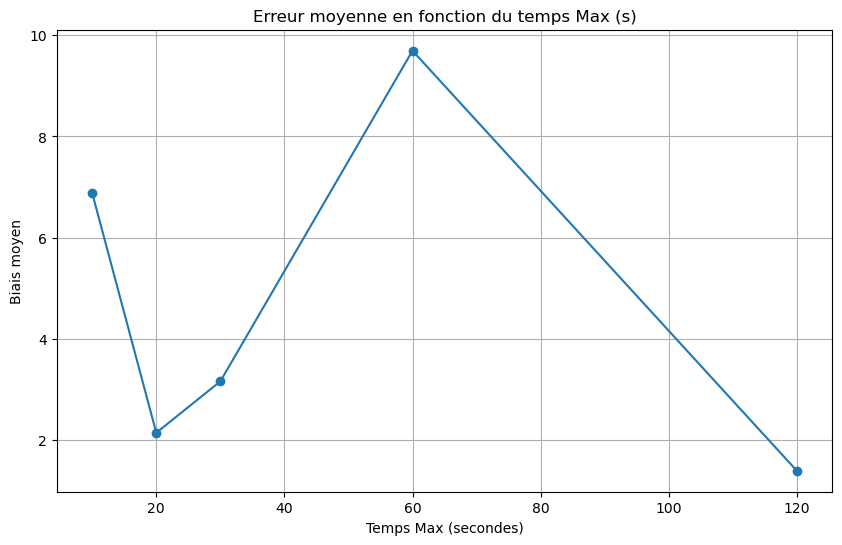

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, err, marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

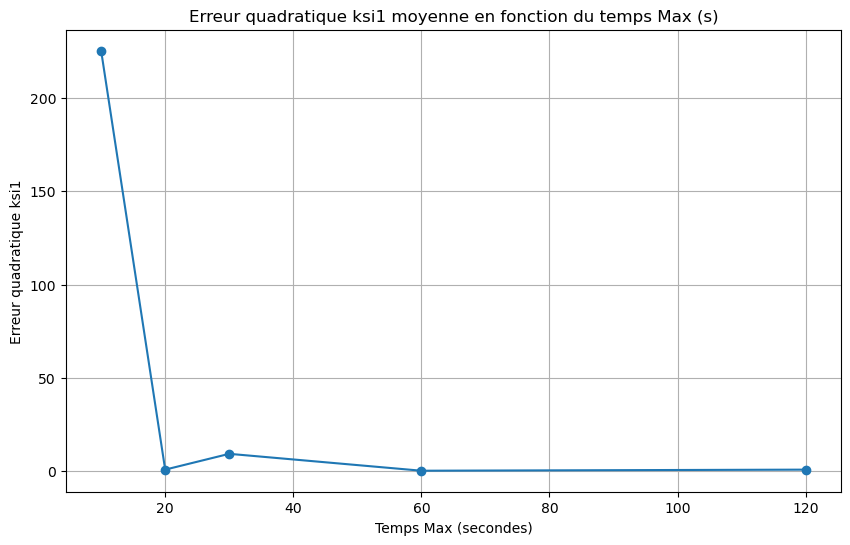

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, errquadksi1, marker='o', linestyle='-')
plt.title('Erreur quadratique ksi1 moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Erreur quadratique ksi1')
plt.grid(True)
plt.show()

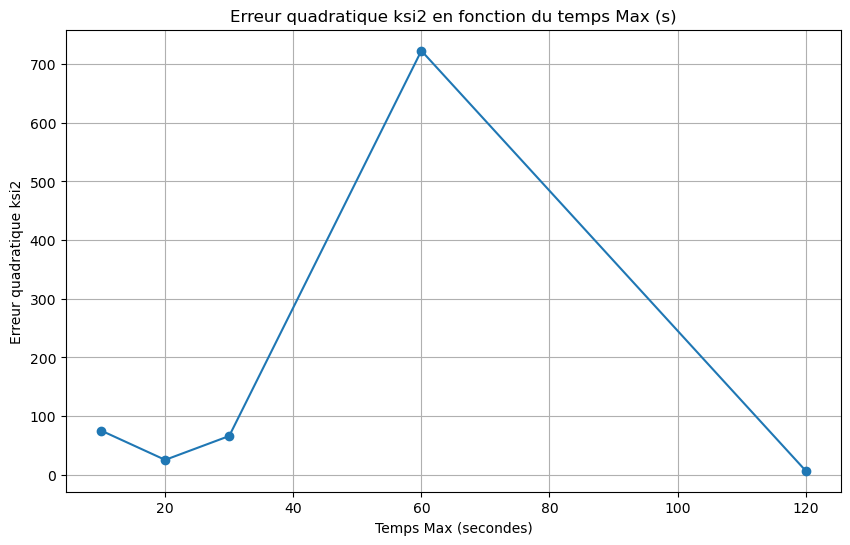

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, errquadksi2, marker='o', linestyle='-')
plt.title('Erreur quadratique ksi2 en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Erreur quadratique ksi2')
plt.grid(True)
plt.show()